## Determine the Distance and % Overlap Between Sequential Annotated Images


In [15]:
# Import libraries and query Aletheia for all annotated images

import time
import numpy as np
import pandas as pd
from datetime import datetime as dt
from brtdevkit.core.db import DBConnector, DatetimeFilter
from matplotlib import pyplot as plt, rcParams
from geopy import distance

def get_shasta_data(filters={}, start=None, end=None, limit=None):
    """
    Query relevant Shasta data for calculations. Written by Andrei P.
    """
    start_time = time.time()
    connector = DBConnector()
    img_filters = {'project_name': 'shasta', **filters}
    if start is not None or end is not None:
        img_filters = [img_filters, DatetimeFilter(key="collected_on", start=start, end=end)]
    df = connector.get_documents_df('image', img_filters, limit=limit)
    elapsed_time = time.time() - start_time
    return df, elapsed_time

# Convert between meters and inches
def in2m(in_val): # inches to meters
    return in_val * 0.0254

def m2in(m_val): # meters to inches
    return m_val / 0.0254

# Set start date for query
start = dt(2021, 3, 29)
end = dt(2021, 7, 30)

# DCMs
dcms = ['DCM-MANATEE', 'DCM-WALRUS', 'DCM-SEAL', 'DCM-OTTER', 'DCM-PORPOISE', 'DCM-DOLPHIN']
machines = ["SHASTA-FB-BRADLEY","SHASTA-FB-PALADIN", "BLACKBIRD", 'ATM-DUCKDUCK', 'ATM-GOOSE']
dcms_2021 = ['DCM11', 'DCM12', 'DCM13', 'DCM14', 'DCM16', 'DCM17','DCM18','DCM19', 'DCM20', 'DCM21','DCM23', 'DCM24','DCM25', 'DCM26', 'DCM27', 'DCM28']
#machines = ["SHASTA-FB-BRADLEY","SHASTA-FB-PALADIN", "BLACKBIRD", 'ATM-DUCKDUCK', 'ATM-GOOSE']
crops = ['COTTON', 'CORN', 'SOYBEANS']

updcms = ['DCM13', 'DCM14', 'DCM28', 'DCM21', 'DCM18', 'DCM23', 'DCM16', 'DCM19']

# Select all annotated images past the start date
filters = {'artifacts.kind':'nrg', 'robot_name':{'$in': dcms_2021}, 'crop_name':{"$in":['COTTON']}, 'has_human_annotation': True
          }

full_df, elapsed_time = get_shasta_data(filters=filters, start=start)
full_df['grower_farm_field'] = full_df['grower'] + '_' + full_df['farm'] +'_' + full_df['operating_field_name']
print(f"Queried {len(full_df)} images in {elapsed_time:.2f} s.")

Queried 16826 images in 26.67 s.


In [16]:
# Create 'annotation_distances' dataframe of relevant features for all annotated images

# Filter for dcms, machines or both
qdf = full_df[full_df.has_human_annotation ==True] 
print(f'There are {len(qdf)} annotated images available.')

# Set date filter if desired
#qdf = qdf[qdf['date_collected'] >= '2020-07-01']

distance_prev = []
distance_next = []
ns = []
wk = []
dcms = []
cht = []
fields = []
dc = qdf['robot_name'].unique()

for d in dc:
    ddf = qdf[qdf['robot_name']==d] # Grouping first by robot_name eliminates duplicate field names
    for o in ddf['operating_field_name'].unique():
        op = ddf[ddf['operating_field_name']== o] # Group by operating_field_name
        op = op.sort_values('collected_on') # Sort by timestamp to examine sequential images
        for n in range(1,len(op)-1):
            previous_lat_long = [op.latitude[n-1], op.longitude[n-1]] # Retrieve coordinates of previous image
            current_lat_long = [op.latitude[n], op.longitude[n]] # Retrieve coordinates of current image
            next_lat_long = [op.latitude[n+1], op.longitude[n+1]] # Retrieve coordinates of next image
            distance_from_previous = distance.distance(previous_lat_long, current_lat_long).meters
            distance_from_next = distance.distance(next_lat_long, current_lat_long).meters
            distance_prev.append(distance_from_previous)
            distance_next.append(distance_from_next)
            cht.append(op.camera_height[n])
            fields.append(o)
            dcms.append(d)
            ns.append(len(op))

annotation_distances = pd.DataFrame({'dcm_name':dcms, 'camera_height':cht, 'operating_field_name':fields,
                                     'n_images_annotated':ns, 'distance_from_previous':distance_prev, 'distance_from_next': distance_next})
print(f'There were {len(annotation_distances)} images included in the analysis.')
annotation_distances.head()

There are 16826 annotated images available.
There were 16539 images included in the analysis.


,dcm_name,camera_height,operating_field_name,n_images_annotated,distance_from_previous,distance_from_next
0,DCM12,0.797094,Espejo South 3883-B,103,12.010278,15.010523
1,DCM12,0.819985,Espejo South 3883-B,103,15.010523,7.505261
2,DCM12,0.800416,Espejo South 3883-B,103,7.505261,1.515861
3,DCM12,0.808691,Espejo South 3883-B,103,1.515861,3.002105
4,DCM12,0.791530,Espejo South 3883-B,103,3.002105,1.501052


In [10]:
# How much distance is being covered in a field?

fchd = annotation_distances.groupby(['operating_field_name', 'camera_height']).sum()['distance_from_previous']

fchd.median()

4.166052146683611

### Plot Distance Between Sequential Annotated Images

1.0


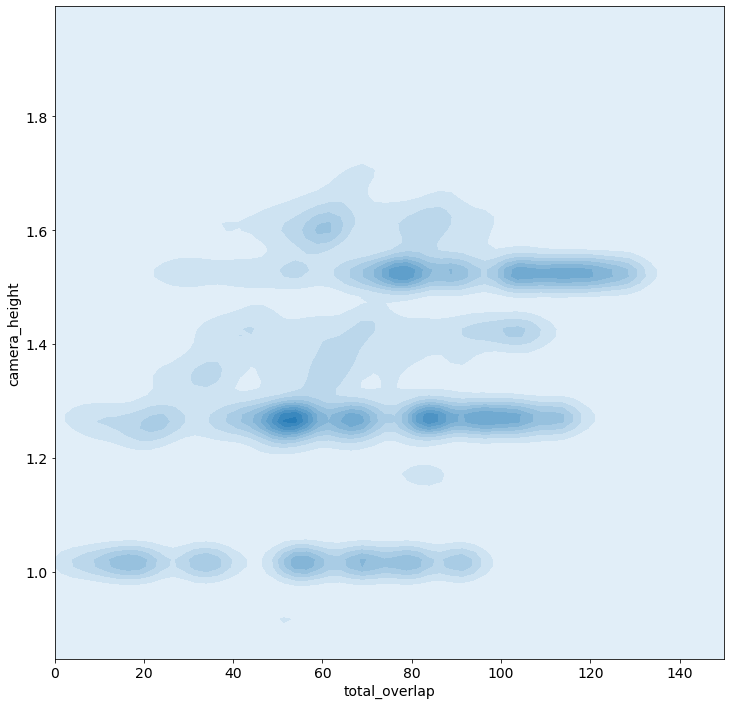

In [346]:
import seaborn as sns

annotation_distances =annotation_distances.dropna()
annotation_distances = annotation_distances[annotation_distances.total_overlap > 0]
print(len(annotation_distances[annotation_distances.total_overlap >0])/len(annotation_distances))

plt.figure(figsize=(8,8))
sns.kdeplot(annotation_distances.total_overlap, annotation_distances.camera_height, shade =True)
plt.xlim(0, 150)
plt.show()

In [314]:
annotation_distances.groupby('dcm_name').median()

,index,week,camera_height,n_images_annotated,distance_from_previous,distance_from_next,image_length,previous_image_length,overlap_with_previous,overlap_with_next,total_overlap
dcm_name,,,,,,,,,,,
DCM-DOLPHIN,46713.5,24.0,1.4224,542.0,1.022908,1.022931,1.618948,1.618948,39.809118,39.707371,76.667726
DCM-MANATEE,178370.0,24.0,1.2700,993.0,0.814208,0.814209,1.445490,1.445490,42.971207,42.971186,88.065728
DCM-OTTER,349471.5,24.0,1.3970,1036.0,1.270029,1.270029,1.590038,1.590038,29.225500,29.225450,60.012106
DCM-PORPOISE,528332.0,30.0,2.0066,499.0,1.102094,1.102094,2.283873,2.283873,51.744485,51.744485,107.366707
DCM-SEAL,461483.5,25.0,1.5240,628.0,1.056166,1.056167,1.734588,1.734588,39.103728,39.099836,77.917716
DCM-WALRUS,507649.0,25.0,1.5240,1331.0,0.748035,0.748036,1.734588,1.734588,53.076810,53.076804,101.520089


The median distance between sequential annotated images is 4.36 meters


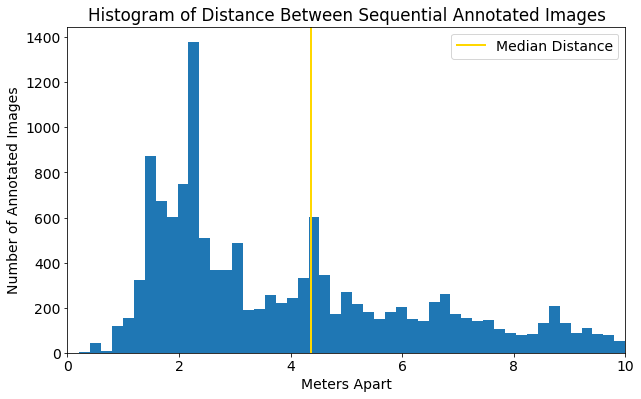

In [17]:
med_dist = annotation_distances.distance_from_previous.median()
#print(f'There are annotated images from {len(annotation_distances.operating_field_name.unique())} unique fields')
print(f'The median distance between sequential annotated images is {med_dist:.2f} meters')

# Just for the histogram, filter out very distant images (i.e from different areas within a field)
in_field_images = annotation_distances[annotation_distances.distance_from_previous < 10] 

plt.figure(figsize=(10,6))
plt.title('Histogram of Distance Between Sequential Annotated Images')
plt.hist(in_field_images['distance_from_previous'], bins=50)
plt.xlabel('Meters Apart')
plt.xlim(0,10)
plt.ylabel('Number of Annotated Images')
plt.axvline(med_dist, linewidth=2, color = 'gold')
plt.legend(['Median Distance'])
plt.savefig('annotation_distances.png')
plt.show()

### Calculate Vertical (Top to Bottom) Image Length

The median vertical image length is 1.59 meters


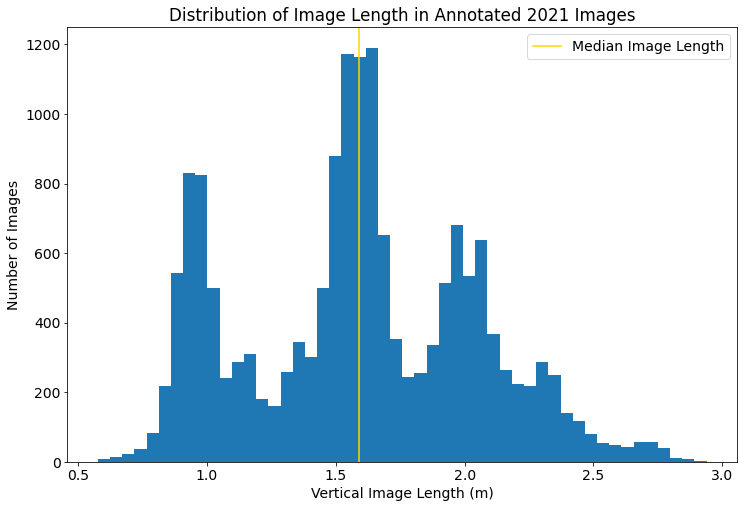

In [18]:
rcParams['font.size'] = 14 # Set global font size for plots

def calc_distance(z, theta, fov_v):
    """
    Calculate the linear distance covered from the top to the bottom of an image.
    """
    xmin = z * np.tan(theta - (fov_v / 2.0))
    xmax = z * np.tan(theta + (fov_v / 2.0))
    return xmin, xmax

# DCM-specific camera variables for angle and vertical Field of View (FOV)
# In practice these will somewhat variable but for this analysis they are treated as fixed values
fov_v = np.radians(45.7)
theta = np.radians(28)

# Calculate vertical image length
annotation_distances['image_length'] = calc_distance((annotation_distances['camera_height']), theta,fov_v)[1]-calc_distance((annotation_distances['camera_height']), theta,fov_v)[0]
annotation_distances = annotation_distances[annotation_distances.image_length < 4].reset_index() # Remove few obvious sensor error data points
annotation_distances['previous_image_length'] = annotation_distances.image_length.shift(1) # store previous image length for later calculations
print(f'The median vertical image length is {np.median(annotation_distances.image_length):.2f} meters')

# Plot histogram of image length
plt.figure(figsize=(12,8))
plt.title('Distribution of Image Length in Annotated 2021 Images')
plt.ylabel('Number of Images')
plt.xlabel('Vertical Image Length (m)')
plt.hist(annotation_distances.image_length, bins=50)
plt.axvline(np.median(annotation_distances.image_length), color='gold')
plt.legend(['Median Image Length'])
#plt.xlim(0,3)
#plt.savefig('image_length.png')
plt.show()

### Calculate Overlap

For any annotated image, there are two potential sources of image overlap: overlap with the previous image and overlap with the next image. 

overlap_with_previous_image = (length of image [n-1] - distance between image[n-1] and image [n])/length of image [n]

overlap_with_next_image = (length of image [n] - distance between image[n] and image [n+1] )/length of image [n]

total_overlap = overlap_with_previous_image + overlap_with_next_image


![](overlap_diagram.png)

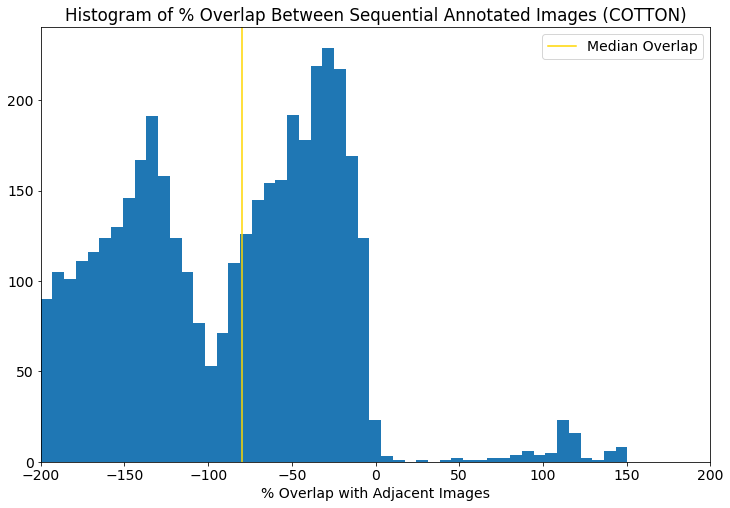

Median image overlap is -488.4%
99.45% of annotated images have 0% overlap
99.48% of annotated images have less than 25% overlap
99.50% of annotated images have less than 50% overlap
99.53% of annotated images have less than 75% overlap
0.38% of annotated images have >=100% overlap


In [19]:
# Calculate and plot % Overlap between images
annotation_distances['overlap_with_previous'] = ((annotation_distances['previous_image_length']-annotation_distances['distance_from_previous'])/annotation_distances['image_length'])*100
annotation_distances['overlap_with_next'] = ((annotation_distances['image_length']-annotation_distances['distance_from_next'])/annotation_distances['image_length'])*100
annotation_distances['total_overlap'] = annotation_distances.overlap_with_previous + annotation_distances.overlap_with_next

# For histogram, remove extreme values
within_field = annotation_distances[(annotation_distances['total_overlap']>-200)&(annotation_distances['total_overlap']<200)]

plt.figure(figsize=(12,8))
plt.title('Histogram of % Overlap Between Sequential Annotated Images (COTTON)')
plt.hist(within_field['total_overlap'], bins=50)
#plt.axvline(25, color='gold')
plt.axvline(np.median(within_field['total_overlap']), color='gold')
plt.xlabel('% Overlap with Adjacent Images')
plt.xlim(-200, 200)
plt.legend(['Median Overlap'])
plt.savefig('Overlap.png')
plt.show()

print(f'Median image overlap is {np.median(annotation_distances.total_overlap.dropna()):.1f}%')
print(f'{((len(annotation_distances[annotation_distances.total_overlap<=0])/len(annotation_distances))*100):.2f}% of annotated images have 0% overlap')
print(f'{((len(annotation_distances[annotation_distances.total_overlap<=25])/len(annotation_distances))*100):.2f}% of annotated images have less than 25% overlap')
print(f'{((len(annotation_distances[annotation_distances.total_overlap<=50])/len(annotation_distances))*100):.2f}% of annotated images have less than 50% overlap')
print(f'{((len(annotation_distances[annotation_distances.total_overlap<=75])/len(annotation_distances))*100):.2f}% of annotated images have less than 75% overlap')
print(f'{((len(annotation_distances[annotation_distances.total_overlap>=100])/len(annotation_distances))*100):.2f}% of annotated images have >=100% overlap')

In [291]:
# Look at two example images around an index l

qdf = full_df.copy()
qdf.sort_values('collected_on', ascending=False)
l = 2000

img1 = qdf.iloc[l]
img2 = qdf.iloc[l+1]

first_lat_long = [img1['latitude'], img1['longitude']]
last_lat_long = [img2['latitude'], img2['longitude']]
dist_travelled = distance.distance(first_lat_long, last_lat_long).meters

print(f'These images are {dist_travelled:.2f} meters apart')
print(qdf.iloc[l-1]['_id'])
print(qdf.iloc[l]['_id'])
print(qdf.iloc[l+1]['_id'])

camera_height       1.4224
row_spacing      INCHES_40
Name: 5ea0ec0fee4204a8fd83c4cc, dtype: object
These images are 0.76 meters apart
5ea0ec0fee4204a8fd83c4c2
5ea0ec0fee4204a8fd83c4cc
5ea0ec0fee4204a8fd83c4d6


In [296]:
print(annotation_distances.iloc[2002]['total_overlap'])

28.403814787354108


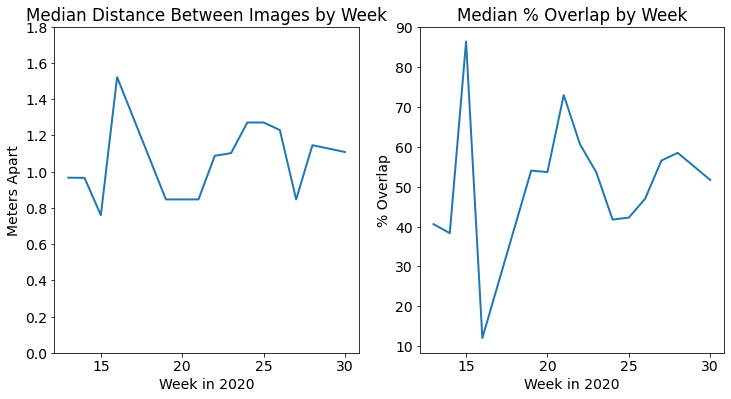

In [277]:
# plot distance by week of the year

week_dist = annotation_distances.groupby('week').median()

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(week_dist['distance_from_previous'], linewidth=2)
plt.title('Median Distance Between Images by Week')
plt.ylabel('Meters Apart')
plt.ylim(0, 1.8)
plt.xlabel('Week in 2020')
plt.subplot(122)
plt.plot(week_dist['total_overlap'], linewidth=2)
plt.title('Median % Overlap by Week')
plt.ylabel('% Overlap')
plt.xlabel('Week in 2020')
plt.savefig('annotations.png')
plt.show()

In [ ]:
# Calculate median distance and 5 overlap covered by individual DCMs and machines

machines = annotation_distances.groupby('dcm_name').median().sort_values('distance_covered')
machines[machines['distance_covered']>0][['distance_covered', 'overlap']]

1895
4    262
1    256
2    141
3    103
Name: collected_on, dtype: int64


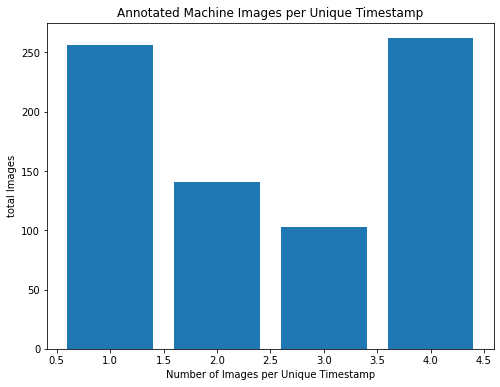

Index(['_id', 'angle_to_row', 'annotations', 'artifacts',
       'artifacts_content_hash', 'camera_exposure_algo',
       'camera_exposure_time', 'camera_focal_length', 'camera_fstop',
       'camera_gain', 'camera_height', 'camera_manufacturer',
       'camera_revision', 'camera_sensor_name', 'camera_sensor_type',
       'camera_serial', 'cloud_cover', 'collected_on', 'crop_damage',
       'crop_health', 'crop_height', 'crop_name', 'crop_residue',
       'experiment_id', 'farm', 'furrow_depth_inches', 'gnss', 'gps_course',
       'gps_quality', 'gps_speed', 'group_id', 'grower',
       'has_human_annotation', 'icp_version', 'is_deleted', 'isp_version',
       'latitude', 'longitude', 'no_crop_metadata', 'notes',
       'operating_field_name', 'operator_name', 'project_name',
       'raw_bit_depth', 'robot_name', 'row_spacing', 'soil_color',
       'tillage_practice', 'type', 'uuid', 'weed_pressure', 'weeds',
       'date_collected', 'lat_lon'],
      dtype='object')


In [72]:
# Identify identical lat/longs and display how many images share them

qdf = full_df.copy()
qdf['lat_lon'] = qdf.apply(lambda x: (x['latitude'], x['longitude']), axis=1)
ident = qdf['lat_lon'].value_counts().sort_values()
more_than_ten = ident[ident>=10]

tdf = qdf[qdf.lat_lon.isin(more_than_ten.index)]
print(len(tdf))

times = tdf['collected_on'].value_counts().sort_values()
print(times.value_counts())
# Display coordinates of images with >=10 identical lat/longs

#more_than_ten
plt.figure(figsize=(8,6))
plt.bar(x= [4,1,2,3] , height = times.value_counts())
plt.title('Annotated Machine Images per Unique Timestamp')
plt.xlabel('Number of Images per Unique Timestamp')
plt.ylabel('total Images')
plt.savefig('same_times.png')
plt.show()

In [75]:
cams = tdf.camera_serial.value_counts().sort_values()
print(cams)


PCCAMJA000370      4
PCCAMJA000356      5
PCCAMJA000495      7
PCCAMJA000348      7
PCCAMJA000497      8
PCCAMJA000369      9
PCCAMJA000523     15
PCCAMJA000524     16
PCCAMJA000525     17
PCCAMJA000470     22
PCCAMJA000472     22
PCCAMJA000502     42
PCCAMJA000507     43
PCCAMJA000519     43
PCCAMJA000517     43
PCCAMJA000526     44
PCCAMJA000518     48
PCCAMJA000505     49
PCCAMJA000504     54
PCCAMJA000508     55
PCCAMJA000506     56
PCCAMJA000498     57
PCCAMJA000509     64
PCCAMJA000528     79
PCCAMJA000531     79
PCCAMJA000529     80
PCCAMJA000530     80
PCCAMJA000527     98
PCCAMJA000513     98
PCCAMJA000522     99
PCCAMJA000454    100
PCCAMJA000445    101
PCCAMJA000455    104
PCCAMJA000483    105
PCCAMJA000521    142
Name: camera_serial, dtype: int64


In [141]:
# For the above list of identical lat/longs display how many came from each machine

m =[]
for i, j in more_than_ten.index:
    m.append(qdf[(qdf['latitude']==i)&(qdf['longitude']==j)].robot_name.unique())
machines = pd.Series(m)
machines.value_counts()

TypeError: unhashable type: 'numpy.ndarray'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


[SHASTA-FB-BRADLEY]    29
[BLACKBIRD]            10
[DCM-MANATEE]           3
[SHASTA-FB-PALADIN]     2
[ATM-DUCKDUCK]          2
[DCM-DOLPHIN]           1
[SHASTA-MULE]           1
dtype: int64